In [1]:
import sys
sys.path.append("../../")
import numpy as np
from matplotlib import pyplot as plt
import json
import pickle
import os
import torch
from rnn_coach.src.RNN_torch import *
from rnn_coach.src.DynamicSystemAnalyzer import *
from rnn_coach.src.RNN_numpy import *
from rnn_coach.src.Task import *
from rnn_coach.src.DataSaver import *
from latent_circuit_inference.src.LatentCircuit import *
from latent_circuit_inference.src.LatentCircuitFitter import *
from latent_circuit_inference.src.LCAnalyzer import *
from latent_circuit_inference.src.utils import *
from latent_circuit_inference.src.circuit_vizualization import *
import time

def mse_scoring(x, y):
    return np.mean((x - y) ** 2)

def R2(x, y):
    return 1.0 - mse_scoring(x, y)/np.var(y)

In [2]:
# if with datajoint
# rnn_dj  = RNNDJ()
# task_dj  = TaskDJ()
# trainer_dj  = TrainerDJ()
# networks_sorted = (rnn_dj & "activation_name = 'relu'").fetch("rnn_hash", order_by='mse_score')
# top_50_RNNs = networks_sorted[:50]
# top_RNN = top_50_RNNs[0]
# rnn_data = pd.DataFrame((rnn_dj & f"rnn_hash = '{top_RNN}'").fetch())
# task_string = rnn_data["task_hash"][0]
# task_data = pd.DataFrame((task_dj & f"task_hash='{task_string}'").fetch())
# trainer_string = rnn_data["trainer_hash"][0]
# trainer_data = pd.DataFrame((trainer_dj & f"trainer_hash='{trainer_string}'").fetch())

In [3]:
#given the folder, open up the files:
RNN_folder = "0.0075352_20230222-063817"

tag = '8-nodes'
RNN_folder_full_path = os.path.join("../", "../", "rnn_coach", "data", "trained_RNNs", "CDDM", RNN_folder)
mse_score_RNN = os.listdir(RNN_folder_full_path)[0].split("_")[0]
rnn_config = json.load(open(os.path.join(RNN_folder_full_path, f"{mse_score_RNN}_config.json"), "rb+"))
rnn_data = json.load(open(os.path.join(RNN_folder_full_path, f"{mse_score_RNN}_params_CDDM.json"), "rb+"))

# Latent Circuit Inference set up

In [4]:
LCI_config_file = json.load(open(os.path.join("../", "data", "configs", f"LCI_config.json"), mode="r", encoding='utf-8'))
task_data = rnn_config["task_params"]

In [5]:
# defining RNN:
activation_name = rnn_config["activation"]
RNN_N = rnn_config["N"]
if activation_name == 'relu':
    activation_RNN = lambda x: torch.maximum(x, torch.tensor(0))
elif activation_name == 'tanh':
    activation_RNN = torch.tanh
elif activation_name == 'sigmoid':
    activation_RNN = lambda x: 1/(1 + torch.exp(-x))
elif activation_name == 'softplus':
    activation_RNN = lambda x: torch.log(1 + torch.exp(5 * x))
dt = rnn_config["dt"]
tau = rnn_config["tau"]
connectivity_density_rec = rnn_config["connectivity_density_rec"]
spectral_rad = rnn_config["sr"]
sigma_inp = rnn_config["sigma_inp"]
sigma_rec = rnn_config["sigma_rec"]
# seed = LCI_config_file["seed"]
seed = np.random.randint(1000000)
print(f"seed: {seed}")
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
rng = torch.Generator(device=torch.device('cpu'))
if not seed is None:
    rng.manual_seed(seed)
input_size = np.array(rnn_data["W_inp"]).shape[1]
output_size = np.array(rnn_data["W_out"]).shape[0]

seed: 860901


In [6]:
# Task:
n_steps = task_data["n_steps"]

In [7]:
# LC
n = LCI_config_file["n"]
LC_N = LCI_config_file["N"]
W_inp = np.array(LCI_config_file["W_inp"])
W_out = np.array(LCI_config_file["W_out"])
# Fitter:
lambda_w = 0.09 # LCI_config_file["lambda_w"]
max_iter = 1000 # LCI_config_file["max_iter"]
tol = LCI_config_file["tol"]
lr = 0.05 #LCI_config_file["lr"]
actvation_name = LCI_config_file["activation"]
inp_connectivity_mask = np.array(LCI_config_file["inp_connectivity_mask"])
rec_connectivity_mask = np.array(LCI_config_file["rec_connectivity_mask"])
out_connectivity_mask = np.array(LCI_config_file["out_connectivity_mask"])
if activation_name == 'relu':
    activation_LC = lambda x: torch.maximum(x, torch.tensor(0))
elif activation_name == 'tanh':
    activation_LC = torch.tanh
elif activation_name == 'sigmoid':
    activation_LC = lambda x: 1/(1 + torch.exp(-x))
elif activation_name == 'softplus':
    activation_LC = lambda x: torch.log(1 + torch.exp(5 * x))

In [8]:
# # creating instances:
rnn_torch = RNN_torch(N=RNN_N, dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                      activation=activation_RNN, random_generator=rng, device=device)
RNN_params = {"W_inp":np.array(rnn_data["W_inp"]),
              "W_rec":np.array(rnn_data["W_rec"]),
              "W_out":np.array(rnn_data["W_out"]),
              "b_rec":np.array(rnn_data["bias_rec"]),
              "y_init":np.zeros(RNN_N)}
rnn_torch.set_params(RNN_params)

lc = LatentCircuit(n=n,
                   N=LC_N,
                   W_inp=torch.Tensor(W_inp),
                   W_out=torch.Tensor(W_out),
                   inp_connectivity_mask=inp_connectivity_mask,
                   rec_connectivity_mask=rec_connectivity_mask,
                   out_connectivity_mask=out_connectivity_mask,
                   activation=activation_LC,
                   device=device,
                   random_generator=rng)

task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_data)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lc.parameters(), lr=lr)
fitter = LatentCircuitFitter(LatentCircuit=lc, RNN=rnn_torch, Task=task,
                             max_iter=max_iter, tol=tol,
                             optimizer=optimizer, criterion=criterion,
                             lambda_w=lambda_w)



Using cpu for RNN!
Using cpu for Latent Circuit!


In [9]:
tic = time.perf_counter()
lc_inferred, train_losses, val_losses, net_params = fitter.run_training()
toc = time.perf_counter()
print(f"Executed training in {toc - tic:0.4f} seconds")

cpu cpu cpu
cpu cpu cpu
iteration 0, train loss: 3.024357, validation loss: 0.537634
iteration 1, train loss: 2.334523, validation loss: 0.426034
iteration 2, train loss: 1.849741, validation loss: 0.369738
iteration 3, train loss: 1.627301, validation loss: 0.386013
iteration 4, train loss: 1.760829, validation loss: 0.357699
iteration 5, train loss: 1.589625, validation loss: 0.352492
iteration 6, train loss: 1.54947, validation loss: 0.357611
iteration 7, train loss: 1.572143, validation loss: 0.360736
iteration 8, train loss: 1.586262, validation loss: 0.35838
iteration 9, train loss: 1.574597, validation loss: 0.350662
iteration 10, train loss: 1.533283, validation loss: 0.337804
iteration 11, train loss: 1.477163, validation loss: 0.324997
iteration 12, train loss: 1.421499, validation loss: 0.318191
iteration 13, train loss: 1.400372, validation loss: 0.318287
iteration 14, train loss: 1.416882, validation loss: 0.311512
iteration 15, train loss: 1.388653, validation loss: 0.302

iteration 114, train loss: 0.721289, validation loss: 0.172098
iteration 115, train loss: 0.722794, validation loss: 0.170758
iteration 116, train loss: 0.746084, validation loss: 0.167092
iteration 117, train loss: 0.703789, validation loss: 0.177437
iteration 118, train loss: 0.76107, validation loss: 0.190053
iteration 119, train loss: 0.805429, validation loss: 0.160849
iteration 120, train loss: 0.697051, validation loss: 0.17476
iteration 121, train loss: 0.723794, validation loss: 0.172114
iteration 122, train loss: 0.714628, validation loss: 0.158986
iteration 123, train loss: 0.712676, validation loss: 0.199899
iteration 124, train loss: 0.823537, validation loss: 0.171535
iteration 125, train loss: 0.72361, validation loss: 0.181612
iteration 126, train loss: 0.786535, validation loss: 0.182347
iteration 127, train loss: 0.764166, validation loss: 0.183936
iteration 128, train loss: 0.780307, validation loss: 0.165482
iteration 129, train loss: 0.720317, validation loss: 0.18

iteration 239, train loss: 0.57153, validation loss: 0.111834
iteration 240, train loss: 0.485589, validation loss: 0.120807
iteration 241, train loss: 0.524288, validation loss: 0.111721
iteration 242, train loss: 0.492548, validation loss: 0.096881
iteration 243, train loss: 0.431698, validation loss: 0.112399
iteration 244, train loss: 0.494453, validation loss: 0.102937
iteration 245, train loss: 0.463738, validation loss: 0.102523
iteration 246, train loss: 0.461928, validation loss: 0.095099
iteration 247, train loss: 0.425902, validation loss: 0.086735
iteration 248, train loss: 0.390946, validation loss: 0.094365
iteration 249, train loss: 0.422639, validation loss: 0.072595
iteration 250, train loss: 0.325739, validation loss: 0.093218
iteration 251, train loss: 0.420206, validation loss: 0.062863
iteration 252, train loss: 0.293854, validation loss: 0.087367
iteration 253, train loss: 0.375045, validation loss: 0.08306
iteration 254, train loss: 0.35691, validation loss: 0.06

iteration 367, train loss: 0.239454, validation loss: 0.05568
iteration 368, train loss: 0.250289, validation loss: 0.063159
iteration 369, train loss: 0.267132, validation loss: 0.053328
iteration 370, train loss: 0.249835, validation loss: 0.05804
iteration 371, train loss: 0.246958, validation loss: 0.054729
iteration 372, train loss: 0.249194, validation loss: 0.05746
iteration 373, train loss: 0.244586, validation loss: 0.057278
iteration 374, train loss: 0.251244, validation loss: 0.054662
iteration 375, train loss: 0.242091, validation loss: 0.059319
iteration 376, train loss: 0.259764, validation loss: 0.072163
iteration 377, train loss: 0.301779, validation loss: 0.065878
iteration 378, train loss: 0.280383, validation loss: 0.050642
iteration 379, train loss: 0.231859, validation loss: 0.054399
iteration 380, train loss: 0.242728, validation loss: 0.05643
iteration 381, train loss: 0.249103, validation loss: 0.052822
iteration 382, train loss: 0.235795, validation loss: 0.052

iteration 496, train loss: 0.210008, validation loss: 0.061962
iteration 497, train loss: 0.267343, validation loss: 0.052053
iteration 498, train loss: 0.241634, validation loss: 0.046549
iteration 499, train loss: 0.205691, validation loss: 0.055528
iteration 500, train loss: 0.244199, validation loss: 0.047073
iteration 501, train loss: 0.214855, validation loss: 0.052517
iteration 502, train loss: 0.246303, validation loss: 0.0611
iteration 503, train loss: 0.267296, validation loss: 0.04576
iteration 504, train loss: 0.209003, validation loss: 0.059892
iteration 505, train loss: 0.263423, validation loss: 0.056328
iteration 506, train loss: 0.248384, validation loss: 0.049351
iteration 507, train loss: 0.2329, validation loss: 0.057693
iteration 508, train loss: 0.262598, validation loss: 0.055415
iteration 509, train loss: 0.268387, validation loss: 0.053283
iteration 510, train loss: 0.227103, validation loss: 0.051655
iteration 511, train loss: 0.233318, validation loss: 0.0497

iteration 626, train loss: 0.246546, validation loss: 0.045643
iteration 627, train loss: 0.221973, validation loss: 0.063356
iteration 628, train loss: 0.265688, validation loss: 0.057608
iteration 629, train loss: 0.256491, validation loss: 0.046097
iteration 630, train loss: 0.224716, validation loss: 0.050698
iteration 631, train loss: 0.235224, validation loss: 0.048408
iteration 632, train loss: 0.216061, validation loss: 0.046168
iteration 633, train loss: 0.228095, validation loss: 0.052396
iteration 634, train loss: 0.23084, validation loss: 0.048553
iteration 635, train loss: 0.220026, validation loss: 0.045601
iteration 636, train loss: 0.214958, validation loss: 0.0502
iteration 637, train loss: 0.221513, validation loss: 0.047778
iteration 638, train loss: 0.216873, validation loss: 0.045048
iteration 639, train loss: 0.221285, validation loss: 0.048694
iteration 640, train loss: 0.229872, validation loss: 0.05072
iteration 641, train loss: 0.247163, validation loss: 0.045

iteration 756, train loss: 0.265615, validation loss: 0.063093
iteration 757, train loss: 0.278528, validation loss: 0.056484
iteration 758, train loss: 0.247266, validation loss: 0.061918
iteration 759, train loss: 0.268338, validation loss: 0.057145
iteration 760, train loss: 0.251865, validation loss: 0.055162
iteration 761, train loss: 0.244168, validation loss: 0.061121
iteration 762, train loss: 0.267003, validation loss: 0.057341
iteration 763, train loss: 0.278546, validation loss: 0.057987
iteration 764, train loss: 0.237593, validation loss: 0.053126
iteration 765, train loss: 0.244862, validation loss: 0.055696
iteration 766, train loss: 0.245341, validation loss: 0.054552
iteration 767, train loss: 0.235179, validation loss: 0.047794
iteration 768, train loss: 0.209072, validation loss: 0.049412
iteration 769, train loss: 0.223128, validation loss: 0.04906
iteration 770, train loss: 0.221506, validation loss: 0.04471
iteration 771, train loss: 0.211176, validation loss: 0.0

iteration 887, train loss: 0.221457, validation loss: 0.059661
iteration 888, train loss: 0.257829, validation loss: 0.048312
iteration 889, train loss: 0.220063, validation loss: 0.057008
iteration 890, train loss: 0.250642, validation loss: 0.047515
iteration 891, train loss: 0.227426, validation loss: 0.051818
iteration 892, train loss: 0.240321, validation loss: 0.053322
iteration 893, train loss: 0.246872, validation loss: 0.046523
iteration 894, train loss: 0.203396, validation loss: 0.047764
iteration 895, train loss: 0.22558, validation loss: 0.055427
iteration 896, train loss: 0.238672, validation loss: 0.047997
iteration 897, train loss: 0.231848, validation loss: 0.060089
iteration 898, train loss: 0.265788, validation loss: 0.052103
iteration 899, train loss: 0.22679, validation loss: 0.058503
iteration 900, train loss: 0.275761, validation loss: 0.048368
iteration 901, train loss: 0.220949, validation loss: 0.052841
iteration 902, train loss: 0.251725, validation loss: 0.0

In [10]:
# # save the data so that you dont do it again!
# file = f'{top_RNN}_LCI_data_example.pkl'
# pickle.dump(net_params, open(os.path.join("./", file), 'wb+'))

In [11]:
# file = f'{top_RNN}_LCI_data_example.pkl'
# net_params = pickle.load(open(os.path.join("./", file), 'rb+'))

In [12]:
# defining circuit
n = LCI_config_file["n"]
U = net_params["U"]
q = net_params["q"]
Q = q @ U
W_rec = RNN_params["W_rec"]
w_rec_bar = Q @ W_rec @ Q.T
w_rec = net_params["W_rec"]
names = ["ctx m", "ctx c", "mr", "ml", "cr", "cl", "OutR", "OutL"]
w_rec = net_params["W_rec"]
w_inp = net_params["W_inp"]
w_out = net_params["W_out"]
dt = net_params["dt"]
tau = net_params["tau"]
activation_fun_circuit = lambda x: np.maximum(0, x)
circuit = RNN_numpy(N=n, W_rec=w_rec, W_inp=w_inp, W_out=w_out, dt=dt, tau=tau, activation=activation_fun_circuit)
circuit.y = np.zeros(n)

In [13]:
# defining RNN
N = rnn_data["N"]
x = np.random.randn(n)
W_rec = RNN_params["W_rec"]
W_inp = RNN_params["W_inp"]
W_out = RNN_params["W_out"]
dt = net_params["dt"]
tau = net_params["tau"]
activation_fun_RNN = lambda x: np.maximum(0, x)
RNN = RNN_numpy(N=N, W_rec=W_rec, W_inp=W_inp, W_out=W_out, dt=dt, tau=tau, activation=activation_fun_RNN)
RNN.y = np.zeros(n)

In [14]:
# defining analyzer
node_labels = ['ctx m', "ctx c", "mR", "mL", "cR", "cL", "OutR", "OutL"]
analyzer = LCAnalyzer(circuit, labels=node_labels)
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
mask = np.array(rnn_config["mask"])

In [15]:
#MSE mse_score_RNN
score_function = lambda x, y: np.mean((x - y) ** 2)
mse_score = analyzer.get_validation_score(scoring_function=mse_scoring,
                                          input_batch=input_batch_valid,
                                          target_batch=target_batch_valid,
                                          mask=mask,
                                          sigma_rec=sigma_rec,
                                          sigma_inp=sigma_inp)
mse_score = np.round(mse_score, 8)
print(f"MSE: {mse_score}")

MSE: 0.04445435


In [16]:
# Total variance
batch_size = input_batch_valid.shape[2]
RNN.clear_history()
circuit.clear_history()
RNN_trajectories, RNN_output = RNN.run_multiple_trajectories(input_timeseries=input_batch_valid, sigma_rec=0, sigma_inp=0)
lc_trajectories, lc_output = circuit.run_multiple_trajectories(input_timeseries=input_batch_valid, sigma_rec=0, sigma_inp=0)

In [17]:
lc_trajectories_emb = np.swapaxes(Q.T @ np.swapaxes(lc_trajectories, 0, 1), 0, 1)
RNN_trajectories_proj = np.swapaxes(Q @ np.swapaxes(RNN_trajectories, 0, 1), 0, 1)
r2_tot = np.mean([R2(lc_trajectories_emb[:, mask, i], RNN_trajectories[:, mask, i]) for i in range(batch_size)])
r2_proj = np.mean([R2(lc_trajectories[:, mask, i], RNN_trajectories_proj[:, mask, i]) for i in range(batch_size)])
print(f"Total R2: {r2_tot}")
print(f"Projected R2: {r2_proj}")
scores = {"mse_score": mse_score, "r2_tot":r2_tot, "r2_proj" : r2_proj}

Total R2: 0.8389391936509776
Projected R2: 0.9349114032952226


In [18]:
data_folder = os.path.join(LCI_config_file["data_folder"], RNN_folder, f"{mse_score}_LC_{tag}")
datasaver = DataSaver(data_folder)
datasaver.save_data(scores, f"{mse_score}_LC_scores.pkl")
datasaver.save_data(LCI_config_file, f"{mse_score}_LC_config.json")
datasaver.save_data(net_params, f"{mse_score}_LC_params.pkl")

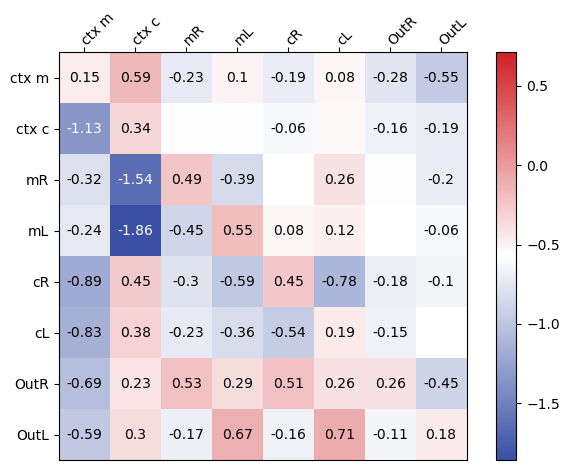

In [19]:
w_rec = net_params["W_rec"]
fig_w_rec = analyzer.plot_recurrent_matrix()
datasaver.save_figure(fig_w_rec, f"{mse_score}_LC_wrec.png")
plt.show()


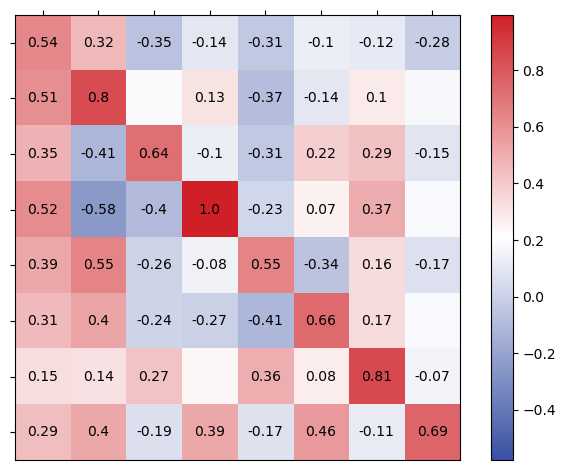

In [20]:
def plot_recurrent_matrix(w_rec):
    fig_w_rec = plt.figure()
    ax = plt.gca()
    labels = []
    im = ax.imshow(w_rec, interpolation='blackman', cmap=cmap)
    fig_w_rec.colorbar(im)
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(labels)
    ax.tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
    plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45,
             ha="right", va="center", rotation_mode="anchor")
    plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45,
             ha="left", va="center", rotation_mode="anchor")

    for (i, j), z in np.ndenumerate(w_rec):
        if np.abs(z) >= 0.05:
            if z >= -1:
                ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
            if z < -1:
                ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='w')
    # ax.set_title("Connectivity matrix", fontsize = 16, pad=10)
    im = ax.imshow(w_rec, interpolation='none', vmin=-np.max(np.abs(w_rec)), vmax=np.max(np.abs(w_rec)), cmap=cmap)
    fig_w_rec.tight_layout()
    return fig_w_rec

fig_w_rec = plot_recurrent_matrix(w_rec_bar)
plt.show()

In [21]:
np.round(net_params["W_out"], 3)

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.636, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.596]],
      dtype=float32)

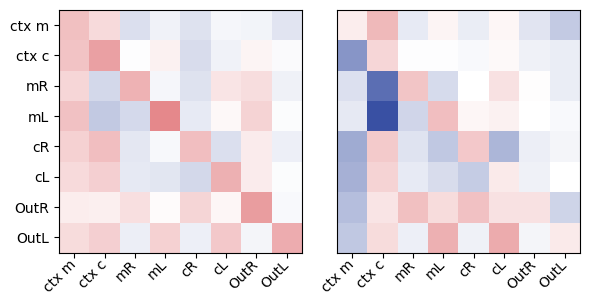

In [22]:
fig_w_rec_comparison = analyzer.plot_recurrent_matrix_comparison(w_rec_bar=w_rec_bar)
datasaver.save_figure(fig_w_rec_comparison, f"{mse_score}_LC_wrec_comparison.png")
plt.show()

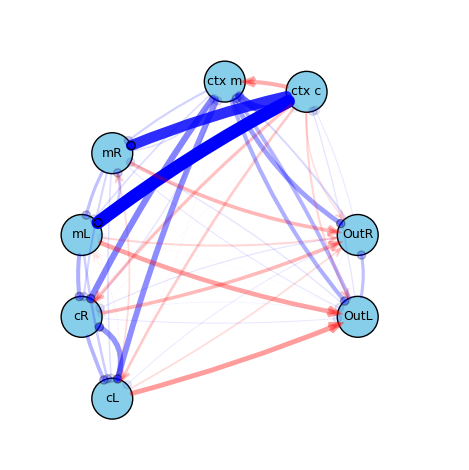

In [23]:
fig_circuit_graph = analyzer.plot_circuit_graph()
datasaver.save_figure(fig_circuit_graph, f"{mse_score}_circuit_graph.png")
plt.show()

In [24]:
def plot_trials(circuit, input_batch, target_batch, mask, sigma_rec=0.03, sigma_inp=0.03, labels=None, rng_numpy=None):
    n_inputs = input_batch.shape[0]
    n_steps = input_batch.shape[1]
    batch_size = input_batch.shape[2]
#     fig_output, axes = plt.subplots(batch_size, 1, figsize=(7, 8))
    fig = plt.figure()
    circuit.clear_history()
    circuit.run_multiple_trajectories(input_timeseries=input_batch,
                                       sigma_rec=0,
                                       sigma_inp=0,
                                       generator_numpy=rng_numpy)
    predicted_output = np.swapaxes((circuit.W_out @ circuit.y_history), 0, 1)
    print(predicted_output.shape)
    plt.plot(predicted_output[:, :, 0].T)
#     colors = ["r", "b", "g", "c", "m", "y", 'k']
#     n_outputs = circuit.W_out.shape[0]
#     for k in range(batch_size):
#         for i in range(n_outputs):
#             tag = labels[i] if not (labels is None) else ''
#             axes[k].plot(predicted_output[i, :, k], color=colors[i], label=f'predicted {tag}')
#             axes[k].plot(mask, target_batch[i, mask, k], color=colors[i], linestyle='--', label=f'target {tag}')
#         axes[k].spines.right.set_visible(False)
#         axes[k].spines.top.set_visible(False)

Plotting random trials
(2, 750, 20)


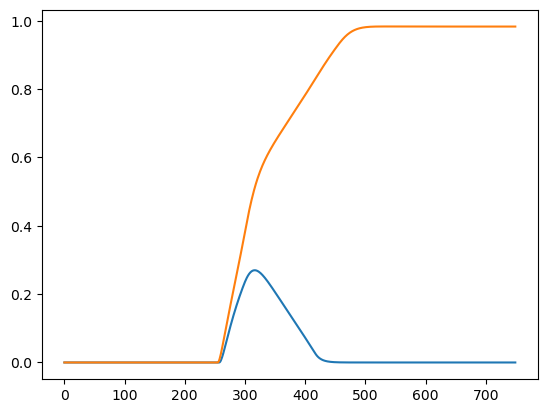

In [25]:
print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 20)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]
circuit.y_init = np.zeros(8)
# fig_trials = analyzer.plot_trials(inputs, targets, mask, sigma_rec=0, sigma_inp=0)
# datasaver.save_figure(fig_trials, f"{mse_score}_LC_random_trials.png")
# plt.show()
plot_trials(circuit, inputs, targets, mask, sigma_rec=0.03, sigma_inp=0.03, labels=None, rng_numpy=None)

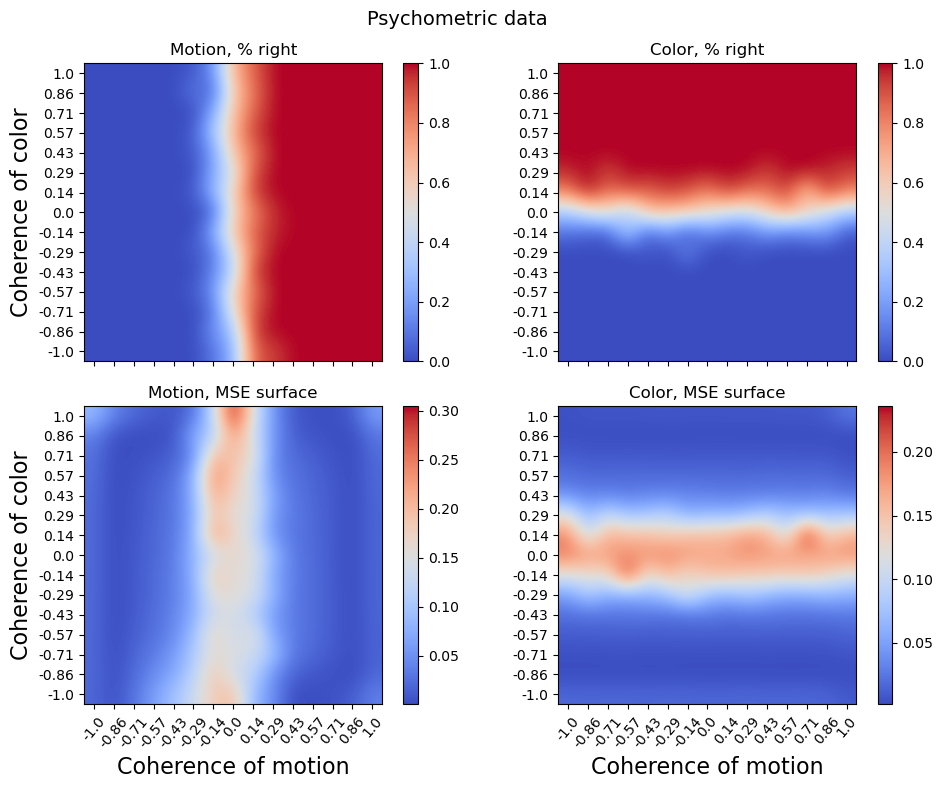

In [26]:
num_levels = len(task_data["coherences"])
analyzer.calc_psychometric_data(task, mask, num_levels=num_levels, num_repeats=31, sigma_rec=0.03, sigma_inp=0.03)
fig_psycho = analyzer.plot_psychometric_data()
datasaver.save_figure(fig_psycho, f"{mse_score}_LC_psychometric.png")
datasaver.save_data(analyzer.psychometric_data, f"{mse_score}_psycho_data.pkl")
plt.show()

Analyzing fixed points
Calculating Line Attractor analytics
Analyzing points on a line attractor in motion context...


  0%|          | 0/31 [00:00<?, ?it/s]

Analyzing points on a line attractor in color context...


  0%|          | 0/31 [00:00<?, ?it/s]

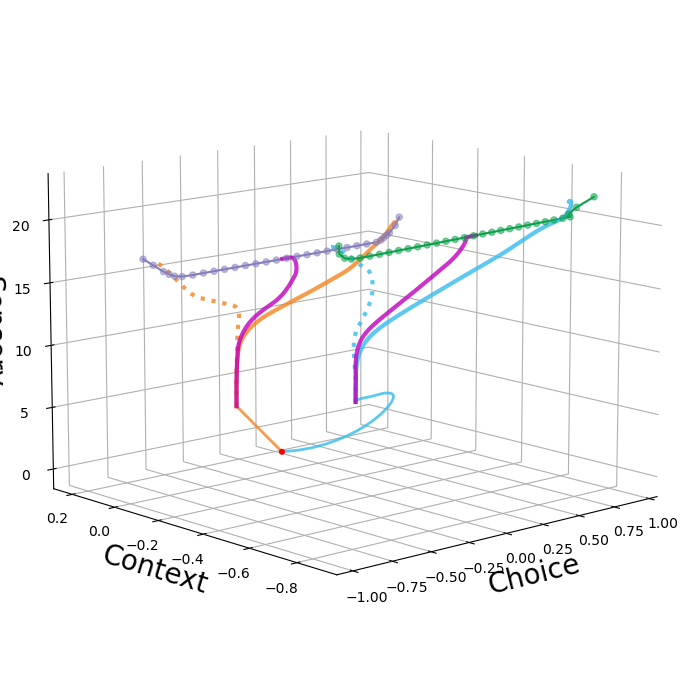

In [27]:
print(f"Analyzing fixed points")
dsa = DynamicSystemAnalyzerCDDM(circuit)
params = {"fun_tol": 0.05,
          "diff_cutoff": 1e-4,
          "sigma_init_guess": 15,
          "patience": 100,
          "stop_length": 100,
          "mode": "approx"}
dsa.get_fixed_points(Input=np.array([1, 0, 0.5, 0.5, 0.5, 0.5]), **params)
dsa.get_fixed_points(Input=np.array([0, 1, 0.5, 0.5, 0.5, 0.5]), **params)
print(f"Calculating Line Attractor analytics")
dsa.calc_LineAttractor_analytics(nudge=0.1)
fig_LA3D = dsa.plot_LineAttractor_3D()
datasaver.save_figure(fig_LA3D, f"{mse_score}_LC_LA3D.png")
datasaver.save_data(dsa.fp_data, f"{mse_score}_fp_data.pkl")
datasaver.save_data(dsa.LA_data, f"{mse_score}_LA_data.pkl")
plt.show()

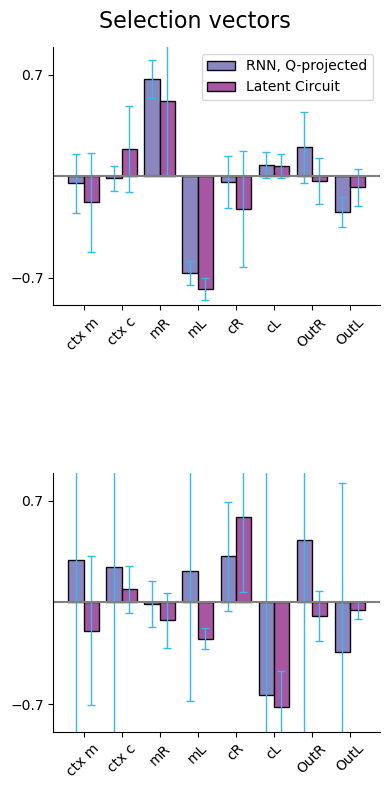

In [28]:
LA_data_lc = pickle.load(open(os.path.join(data_folder, f"{mse_score}_LA_data.pkl"), "rb+"))
LA_data_RNN = pickle.load(open(os.path.join(RNN_folder_full_path, f"{mse_score_RNN}_LA_data.pkl"), "rb+"))
fig_selection_vects = analyzer.plot_selection_vectors(Q, LA_data_lc, LA_data_RNN)
datasaver.save_figure(fig_selection_vects, f"{mse_score}_selection_vects_comparison.png")
plt.show()